In [1]:
%cd ../


/home/hoanghu/projects/Food-Waste-Optimization


In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# 1. Load data

In [4]:
path = "src/data/basic_mvp_data/Biowaste.csv"

biowaste = pd.read_csv(path, delimiter=';')

biowaste.head()

,Date,Ravintola,Asiakasbiojäte. tiski (kg),Biojäte kahvi. porot (kg),Keittiön biojäte (ruoanvalmistus) (kg),Salin biojäte (jämät) (kg)
0,1.1.2023,600 Chemicum,0.0,0.0,0.0,0.0
1,1.1.2023,610 Physicum,0.0,0.0,0.0,0.0
2,1.1.2023,620 Exactum,0.0,0.0,0.0,0.0
3,2.1.2023,600 Chemicum,4.7,1.2,12.0,0.0
4,2.1.2023,610 Physicum,0.0,0.0,0.0,0.0


In [5]:
path = "src/data/basic_mvp_data/tuntidata2.xlsx"

receipts = pd.read_excel(path, header=0)

receipts.head()

,Date,Kuitin tunti,Ravintola,Kuitti kpl
0,2023-01-02,8,600 Chemicum,1
1,2023-01-02,10,600 Chemicum,18
2,2023-01-02,11,600 Chemicum,83
3,2023-01-02,12,600 Chemicum,79
4,2023-01-02,13,600 Chemicum,90


In [6]:
path = "src/data/basic_mvp_data/supersight.xlsx"

occupancy = pd.read_excel(path, header=0, index_col=None)

occupancy.head()

,dateCreated,countIn,countOut,phoneName
0,2024-03-15T04:26:15.000Z,0,1,S63
1,2024-03-15T04:26:24.000Z,1,2,S63
2,2024-03-15T04:26:27.000Z,1,0,S63
3,2024-03-15T05:19:19.000Z,1,0,S63
4,2024-03-15T05:37:09.000Z,1,0,S63


In [7]:
path = "src/data/basic_mvp_data/kumpula_lounaat_kat.csv"

meals = pd.read_csv(path, delimiter=';', header=None)

meals.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,NaN,Ravintola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,600 Chemicum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Total
2,NaN,Kala,%-osuus,Kana,%-osuus,Kasvis,%-osuus,Liha,%-osuus,Not Mapped,...,Kasvis,%-osuus,Liha,%-osuus,Not Mapped,%-osuus,Vegaani,%-osuus,Total,NaN
3,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,...,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,NaN,Lounaat ilman lisämyyntiä,Lounaat ilman lisämyyntiä
4,Total,73 554,"26,4 %",47 233,"16,9 %",1 524,"0,5 %",41 839,"15,0 %",14 822,...,3 910,"5,3 %",7 744,"10,6 %",195,"0,3 %",31 626,"43,2 %",73 132,397 770


# 2. Pre-process

## With `biowaste`

In [8]:
biowaste['Date'] = biowaste['Date'].apply(lambda x: datetime.strptime(x, r"%d.%m.%Y"))

biowaste.loc[:, 'Ravintola'] = biowaste['Ravintola'].replace({
    "600 Chemicum": "Chemicum",
    "610 Physicum": "Physicum",
    "620 Exactum": "Exactum"
})

biowaste = biowaste.rename(columns={
    'Date': 'date',
    'Ravintola': 'restaurant', 
    'Asiakasbiojäte. tiski (kg)': 'amnt_waste_customer', 
    'Biojäte kahvi. porot (kg)': 'amnt_waste_coffee', 
    'Keittiön biojäte (ruoanvalmistus) (kg)': 'amnt_waste_kitchen',
    'Salin biojäte (jämät) (kg)': 'amnt_waste_hall',
})

# Filter out rows which all 4 types of waste have zero amount
cols = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
tmp = biowaste[cols].sum(axis=1)
biowaste = biowaste[tmp > 0]

biowaste.head()

,date,restaurant,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
3,2023-01-02,Chemicum,4.70,1.2,12.0,0.0
6,2023-01-03,Chemicum,5.00,1.4,14.8,0.0
9,2023-01-04,Chemicum,4.15,4.0,7.1,0.0
12,2023-01-05,Chemicum,10.00,3.3,8.5,0.0
24,2023-01-09,Chemicum,7.65,2.1,4.9,0.0


## With `receipts`

In [9]:
receipts.loc[:, 'Ravintola'] = receipts['Ravintola'].replace({
    "600 Chemicum": "Chemicum",
    "610 Physicum": "Physicum",
    "620 Exactum": "Exactum"
})
    
receipts = receipts.rename(columns={
    'Date': 'date',
    'Kuitin tunti': 'hour',
    'Ravintola': 'restaurant',
    'Kuitti kpl': 'num_rcpts'
})

receipts = receipts.groupby(['date', 'restaurant'])['num_rcpts'].sum().reset_index()

receipts.head()

,date,restaurant,num_rcpts
0,2023-01-02,Chemicum,272
1,2023-01-03,Chemicum,327
2,2023-01-04,Chemicum,351
3,2023-01-04,Physicum,1
4,2023-01-05,Chemicum,437


## With `occupancy`

Since we only concern about how occupancy data relates to the Unicafe data, only camera `S163`, `S216` and `S217` are focused

In [10]:
phoneName2restaurant = {
    'S163': 'Exactum',
    'S216': 'Chemicum',
    'S217': 'Physicum',
}

occupancy = occupancy[occupancy['phoneName'].isin(phoneName2restaurant.keys())]
occupancy['restaurant'] = occupancy['phoneName'].apply(lambda x: phoneName2restaurant[x])

occupancy.head()

,dateCreated,countIn,countOut,phoneName,restaurant
1138,2024-03-15T06:45:23.000Z,1,0,S163,Exactum
1139,2024-03-15T06:51:18.000Z,0,1,S163,Exactum
1140,2024-03-15T07:58:16.000Z,0,1,S163,Exactum
1141,2024-03-15T08:23:55.000Z,1,0,S163,Exactum
1142,2024-03-15T08:47:09.000Z,0,1,S163,Exactum


In [11]:
# Convert index
occupancy['date'] = pd.to_datetime(occupancy['dateCreated']).dt.tz_localize(None)
occupancy = occupancy.set_index('date')

# Accumulate countIn, countOut by day
cols = ['countIn', 'countOut', 'restaurant']
occupancy = occupancy[cols].groupby(by='restaurant').resample('D').sum()

# Reset date
occupancy = occupancy[['countIn', 'countOut']].reset_index()

# Rename columns' name
occupancy = occupancy.rename(columns={
    'countIn': 'num_customer_in',
    'countOut': 'num_customer_out'
})

occupancy.head()

,restaurant,date,num_customer_in,num_customer_out
0,Chemicum,2024-05-27,11,6
1,Chemicum,2024-05-28,767,709
2,Chemicum,2024-05-29,671,677
3,Chemicum,2024-05-30,717,697
4,Chemicum,2024-05-31,689,668


## With `meals`

In [12]:
cols_name = [
    'num_fish', 'percent_fish', 
    'num_chicken', 'percent_chicken',
    'num_vegetable', 'percent_vegetable', 
    'num_meat', 'percent_meat',
    'num_NotMapped', 'percent_NotMapped',
    'num_vegan', 'percent_vegan',
    'total' 
]
len_cols_per_restaurant = len(cols_name) - 1

restaurants = ['Chemicum', 'Physicum', 'Exactum']

cols_important = ['date', 'restaurant', 'num_fish', 'num_chicken', 'num_vegetable', 'num_meat', 'num_NotMapped', 'num_vegan']

def _f_process(x: str):
    x = x.replace(' %', '')
    x = x.replace(' ', '')
    x = x.replace(',', '.')
    
    ret = float(x)

    return ret

In [13]:
# Get date column
dates = meals.loc[5:, 0].apply(lambda x: datetime.strptime(x, r"%Y-%m-%d"))

# Extract restaurant sold meals data
data_restaurants = []

idx_col = 1
for restaurant in restaurants:
    df_restaurant = meals.loc[5:, idx_col:idx_col + len_cols_per_restaurant].copy()

    df_restaurant = df_restaurant.set_axis(cols_name, axis=1)

    df_restaurant = df_restaurant.map(_f_process)

    df_restaurant['restaurant'] = restaurant
    df_restaurant['date'] = dates.copy()

    df_restaurant = df_restaurant[cols_important]
    
    data_restaurants.append(df_restaurant)


In [14]:
meals = pd.concat(data_restaurants)

meals.head()

,date,restaurant,num_fish,num_chicken,num_vegetable,num_meat,num_NotMapped,num_vegan
5,2023-01-02,Chemicum,85.0,0.0,0.0,171.0,1.0,91.0
6,2023-01-03,Chemicum,163.0,0.0,32.0,78.0,1.0,120.0
7,2023-01-04,Chemicum,70.0,0.0,0.0,218.0,3.0,137.0
8,2023-01-05,Chemicum,232.0,85.0,0.0,2.0,4.0,178.0
9,2023-01-09,Chemicum,107.0,0.0,0.0,264.0,0.0,207.0


# 3. Create fact tables

In [15]:
date_start = pd.to_datetime('2023-01-02')
date_end = pd.to_datetime('2024-07-02')

date_range = pd.date_range(date_start, date_end, freq='B')

fact = pd.concat(
    [
        pd.DataFrame({
            'date': date_range,
            'restaurant': restaurant
        })
        for restaurant in restaurants
    ]
)

In [16]:
foreign_keys = ['restaurant', 'date']

fact = fact\
    .merge(meals, on=foreign_keys, how='left')\
    .merge(occupancy, on=foreign_keys, how='left')\
    .merge(receipts, on=foreign_keys, how='left')\
    .merge(biowaste, on=foreign_keys, how='left')

fact.head()

,date,restaurant,num_fish,num_chicken,num_vegetable,num_meat,num_NotMapped,num_vegan,num_customer_in,num_customer_out,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,85.0,0.0,0.0,171.0,1.0,91.0,NaN,NaN,272.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,163.0,0.0,32.0,78.0,1.0,120.0,NaN,NaN,327.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,70.0,0.0,0.0,218.0,3.0,137.0,NaN,NaN,351.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,232.0,85.0,0.0,2.0,4.0,178.0,NaN,NaN,437.0,10.00,3.3,8.5,0.0
4,2023-01-06,Chemicum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# path_fact = "experiments_hoangle/processed/fact.csv"

# fact.to_csv(path_fact, index=False)

# 4. Find correlations

## 4.1. Correlations between `num_customers` and `foodwaste`

In [18]:
cols_val = ['num_customer_in', 'amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
cols = ['date', 'restaurant', *cols_val]

df_cus_waste = fact[cols]
df_cus_waste = df_cus_waste[~df_cus_waste.isna().any(axis=1)].sort_values('date')

df_cus_waste.head()

,date,restaurant,num_customer_in,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
1098,2024-03-15,Exactum,26.0,8.60,2.08,5.13,0.0
1099,2024-03-18,Exactum,33.0,3.40,0.86,10.60,0.0
1100,2024-03-19,Exactum,234.0,3.76,1.10,5.40,0.0
1101,2024-03-20,Exactum,372.0,6.89,1.56,9.75,0.0
1102,2024-03-21,Exactum,262.0,3.17,1.67,7.89,0.0


In [19]:
correlations = []
for restaurant in df_cus_waste['restaurant'].unique():
    df_cus_waste_restaurant = df_cus_waste[df_cus_waste['restaurant'] == restaurant]

    corr = df_cus_waste_restaurant[cols_val].corr().iloc[0]
    corr['restaurant'] = restaurant

    correlations.append(corr)

In [20]:
cols = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']

df_corr = pd.DataFrame(correlations).melt(id_vars='restaurant', value_vars=cols, value_name='pearson', var_name='waste_type')

df_corr.head()

,restaurant,waste_type,pearson
0,Exactum,amnt_waste_customer,0.038297
1,Chemicum,amnt_waste_customer,-0.619415
2,Exactum,amnt_waste_coffee,0.161498
3,Chemicum,amnt_waste_coffee,-0.479019
4,Exactum,amnt_waste_kitchen,-0.150543


Text(0.5, 1.0, 'Overall')

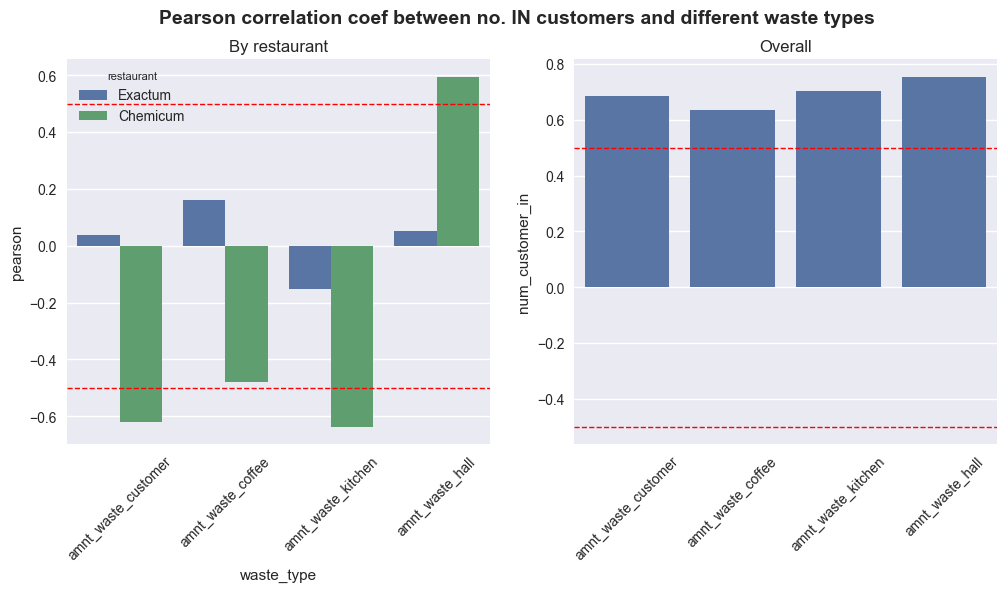

In [21]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Pearson correlation coef between no. IN customers and different waste types", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1, 2, 1)
sns.barplot(data=df_corr, x='waste_type', y='pearson', hue='restaurant', ax=ax)
ax.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=1)
ax.axhline(y = -0.5, color = 'r', linestyle = '--', linewidth=1)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("By restaurant")



ax = fig.add_subplot(1, 2, 2)
df_corr_overall = df_cus_waste.sort_values('date')[cols_val].corr().iloc[0][cols]
sns.barplot(data=df_corr_overall, ax=ax)
ax.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=1)
ax.axhline(y = -0.5, color = 'r', linestyle = '--', linewidth=1)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Overall")



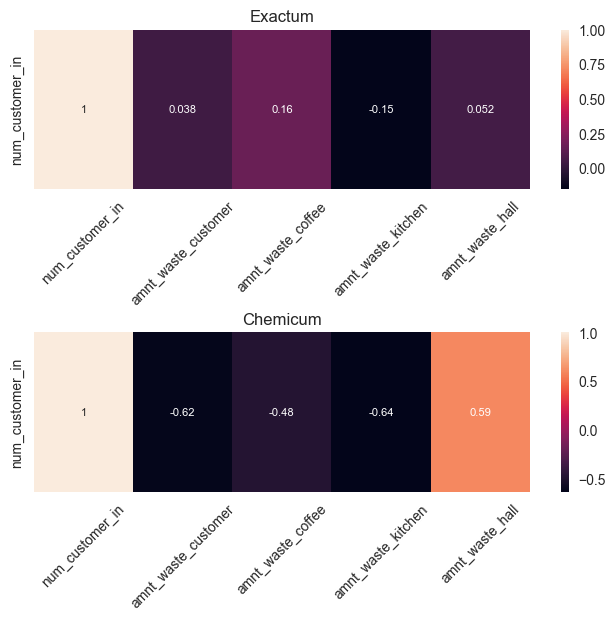

In [22]:
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.9)

for i, restaurant in enumerate(df_cus_waste['restaurant'].unique()):
    df_restaurant = df_cus_waste[df_cus_waste['restaurant'] == restaurant]
    line = df_restaurant[cols_val].corr().iloc[0]
    
    ax = fig.add_subplot(2, 1, i+1)
    sns.heatmap([line.to_numpy()], annot=True)

    ax.set_yticklabels([str(line.name)])
    ax.set_xticklabels(line.index)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(restaurant)

## 4.2. Correlations between `num_rcpts` and `foodwaste`

In [23]:
cols_val = ['num_rcpts', 'amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
cols = ['date', 'restaurant', *cols_val]

df_rcpts_waste = fact[cols]
df_rcpts_waste = df_rcpts_waste[~df_rcpts_waste.isna().any(axis=1)]

df_rcpts_waste.head()

,date,restaurant,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,272.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,327.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,351.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,437.0,10.00,3.3,8.5,0.0
5,2023-01-09,Chemicum,529.0,7.65,2.1,4.9,0.0


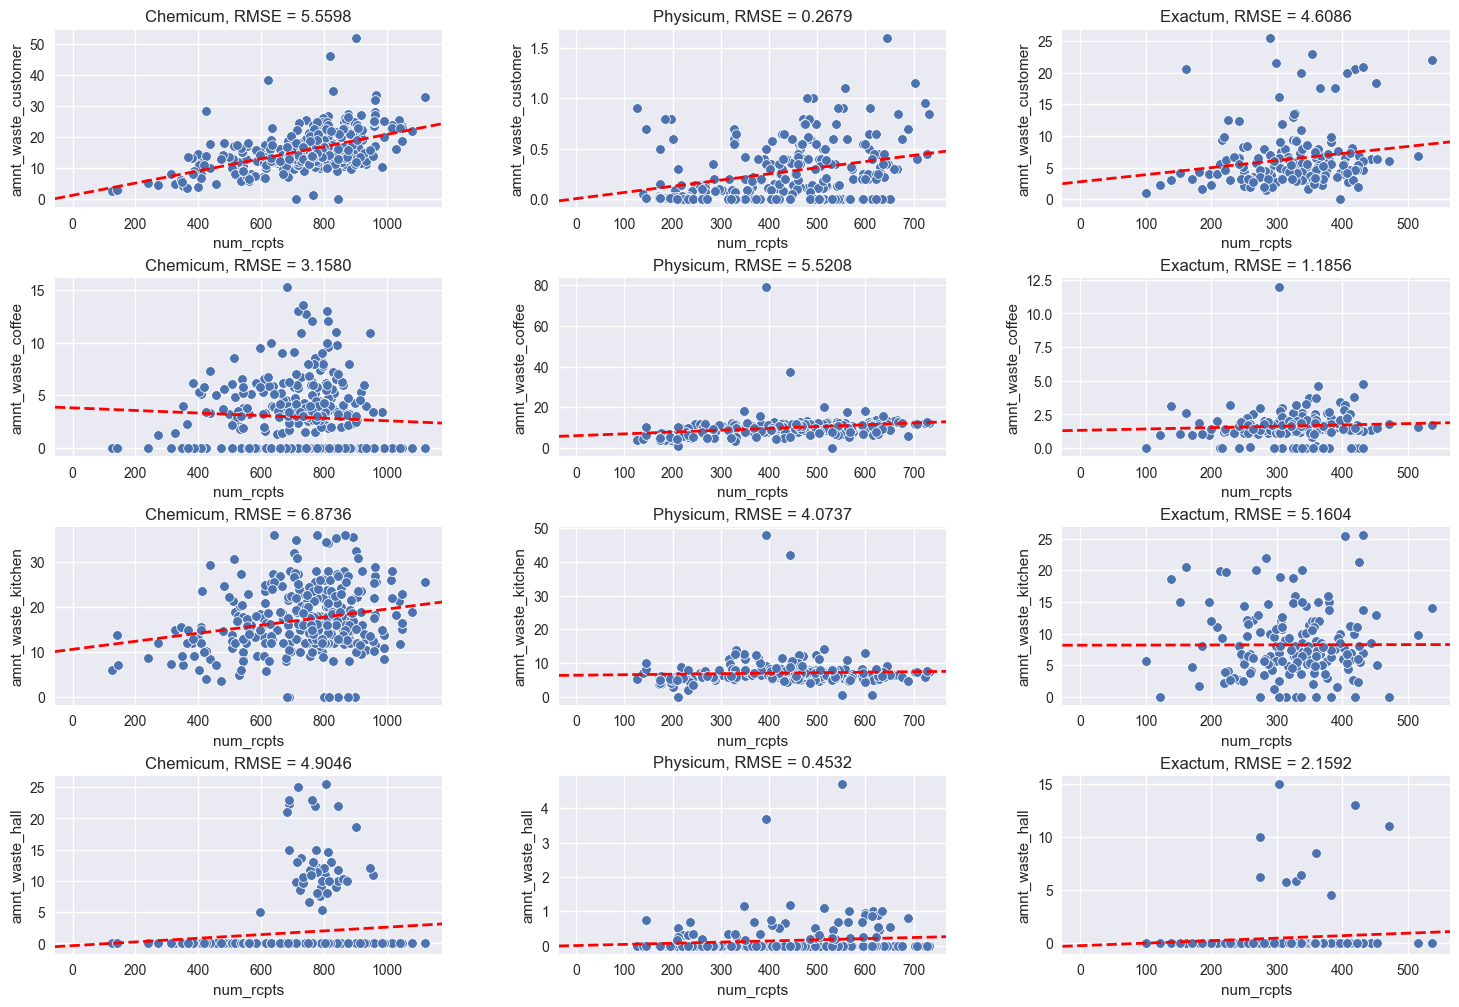

In [24]:
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

waste_types = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
i = 1
for waste in waste_types:
    for restaurant in df_rcpts_waste['restaurant'].unique():

        df_restaurant = df_rcpts_waste[df_rcpts_waste['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)

        sns.scatterplot(df_restaurant, x='num_rcpts', y=waste, ax=ax)

        regressor_linear = LinearRegression()

        X = df_restaurant['num_rcpts'].to_numpy().reshape(-1, 1)
        y = df_restaurant[waste].to_numpy().reshape(-1, 1)
        regressor_linear.fit(X, y)

        y_pred = regressor_linear.predict(X)
        rmse_linear = root_mean_squared_error(y, y_pred)

        m, b = regressor_linear.coef_.item(), regressor_linear.intercept_.item()

        ax.axline(xy1=(0, b), slope=m, color='red', linestyle='--', linewidth=2)
        ax.set_title(f"{restaurant}, RMSE = {rmse_linear:.4f}")

        i += 1


In [26]:
cols

['date',
 'restaurant',
 'num_rcpts',
 'amnt_waste_customer',
 'amnt_waste_coffee',
 'amnt_waste_kitchen',
 'amnt_waste_hall']

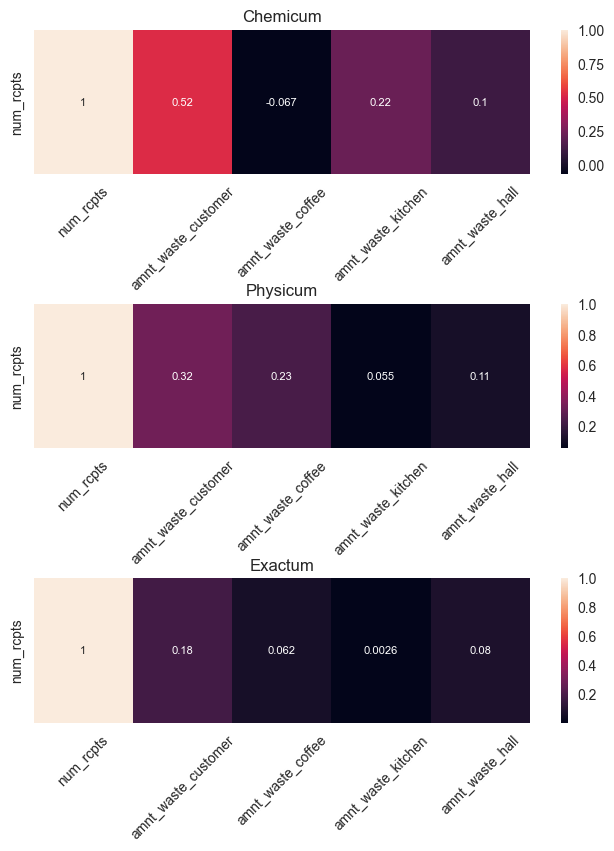

In [27]:
fig = plt.figure(figsize=(8, 9))
plt.subplots_adjust(wspace=0.5, hspace=0.9)

for i, restaurant in enumerate(df_rcpts_waste['restaurant'].unique()):
    df_restaurant = df_rcpts_waste[df_rcpts_waste['restaurant'] == restaurant]
    line = df_restaurant[cols_val].corr().iloc[0]
    
    ax = fig.add_subplot(3, 1, i+1)
    sns.heatmap([line.to_numpy()], annot=True)

    ax.set_yticklabels([str(line.name)])
    ax.set_xticklabels(line.index)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(restaurant)

In [28]:
df_rcpts_waste_wkdate = df_rcpts_waste.copy()

# Extract weekday from date
df_rcpts_waste_wkdate['weekdate'] = df_rcpts_waste['date'].dt.weekday

# Groupby weekdate and restaurant
df_rcpts_waste_wkdate = df_rcpts_waste_wkdate\
    .drop(columns='date')\
    .groupby(['weekdate', 'restaurant'])\
    .sum()\
    .reset_index()

# Replace weekdate from numeric to name
weekdate2name = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
}
df_rcpts_waste_wkdate['weekdate'] = df_rcpts_waste_wkdate['weekdate'].replace(weekdate2name)

df_rcpts_waste_wkdate.head()

,weekdate,restaurant,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,Monday,Chemicum,47919.0,945.00,119.40,995.15,104.80
1,Monday,Exactum,12184.0,206.50,56.53,289.88,5.86
2,Monday,Physicum,22606.0,15.68,462.59,339.38,5.99
3,Tuesday,Chemicum,47992.0,993.55,188.20,983.35,111.10
4,Tuesday,Exactum,12171.0,249.70,66.59,302.18,17.54


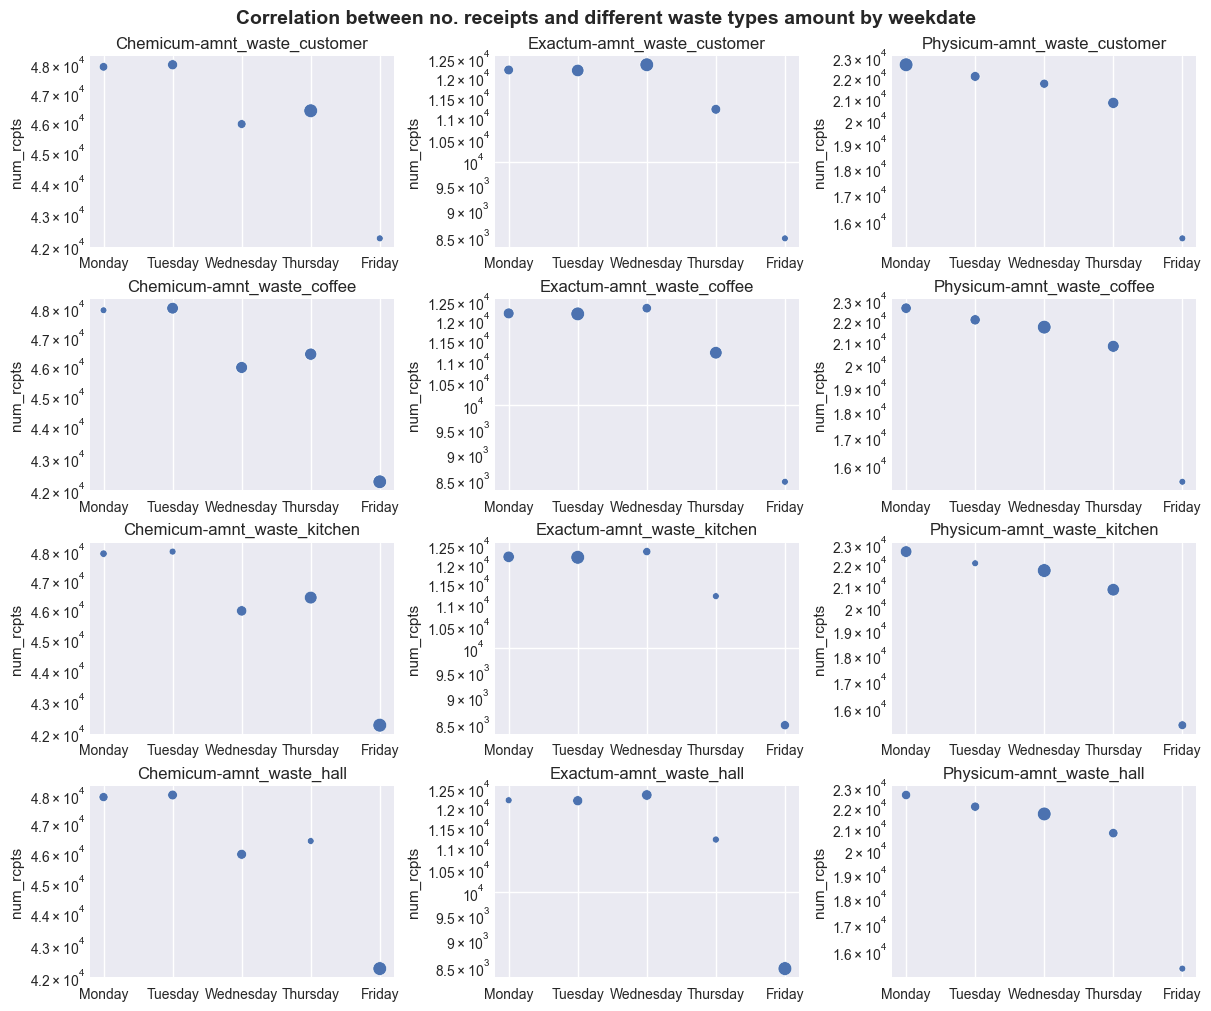

In [29]:
fig = plt.figure(figsize=(12, 10), layout="constrained")
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

fig.suptitle("Correlation between no. receipts and different waste types amount by weekdate", fontsize=14, fontweight="bold")

i = 1
for waste in waste_types:
    for restaurant in df_rcpts_waste_wkdate['restaurant'].unique():
        df_restaurant = df_rcpts_waste_wkdate[df_rcpts_waste_wkdate['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)
        sns.scatterplot(df_restaurant, x='weekdate', y='num_rcpts', size=waste, ax=ax)
        ax.set_yscale('log')
        ax.set(xlabel=None)
        ax.get_legend().remove()
        ax.set_title(f"{restaurant}-{waste}")

        i += 1
    

## 4.3. Correlations between `meals_sold` and `foodwaste`

In [30]:
meal_types = ['num_fish', 'num_chicken', 'num_vegetable', 'num_meat', 'num_NotMapped', 'num_vegan']
waste_types = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
cols = ['date', 'restaurant', *meal_types, *waste_types]

df_meal_waste = fact[cols].copy()
df_meal_waste = df_meal_waste[~df_meal_waste.isna().any(axis=1)]

df_meal_waste.head()

,date,restaurant,num_fish,num_chicken,num_vegetable,num_meat,num_NotMapped,num_vegan,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,85.0,0.0,0.0,171.0,1.0,91.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,163.0,0.0,32.0,78.0,1.0,120.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,70.0,0.0,0.0,218.0,3.0,137.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,232.0,85.0,0.0,2.0,4.0,178.0,10.00,3.3,8.5,0.0
5,2023-01-09,Chemicum,107.0,0.0,0.0,264.0,0.0,207.0,7.65,2.1,4.9,0.0


In [31]:
df_meals_waste_wkdate = df_meal_waste.copy()

# Extract weekday from date
df_meals_waste_wkdate['weekdate'] = df_rcpts_waste['date'].dt.weekday

# Groupby weekdate and restaurant
df_meals_waste_wkdate = df_meals_waste_wkdate\
    .drop(columns='date')\
    .groupby(['weekdate', 'restaurant'])\
    .sum()\
    .reset_index()

# Replace weekdate from numeric to name
weekdate2name = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
}
df_meals_waste_wkdate['weekdate'] = df_meals_waste_wkdate['weekdate'].replace(weekdate2name)

df_meals_waste_wkdate.head()

,weekdate,restaurant,num_fish,num_chicken,num_vegetable,num_meat,num_NotMapped,num_vegan,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,Monday,Chemicum,9846.0,1463.0,78.0,22253.0,2626.0,15893.0,945.00,119.40,995.15,104.80
1,Monday,Exactum,6042.0,1255.0,41.0,14307.0,2193.0,10058.0,206.50,56.53,289.88,5.86
2,Monday,Physicum,8634.0,1324.0,67.0,20173.0,2210.0,14059.0,15.68,462.59,339.38,5.99
3,Tuesday,Chemicum,17123.0,2801.0,768.0,3204.0,2568.0,25770.0,993.55,188.20,983.35,111.10
4,Tuesday,Exactum,9929.0,1636.0,641.0,1944.0,1770.0,15578.0,249.70,66.59,302.18,17.54


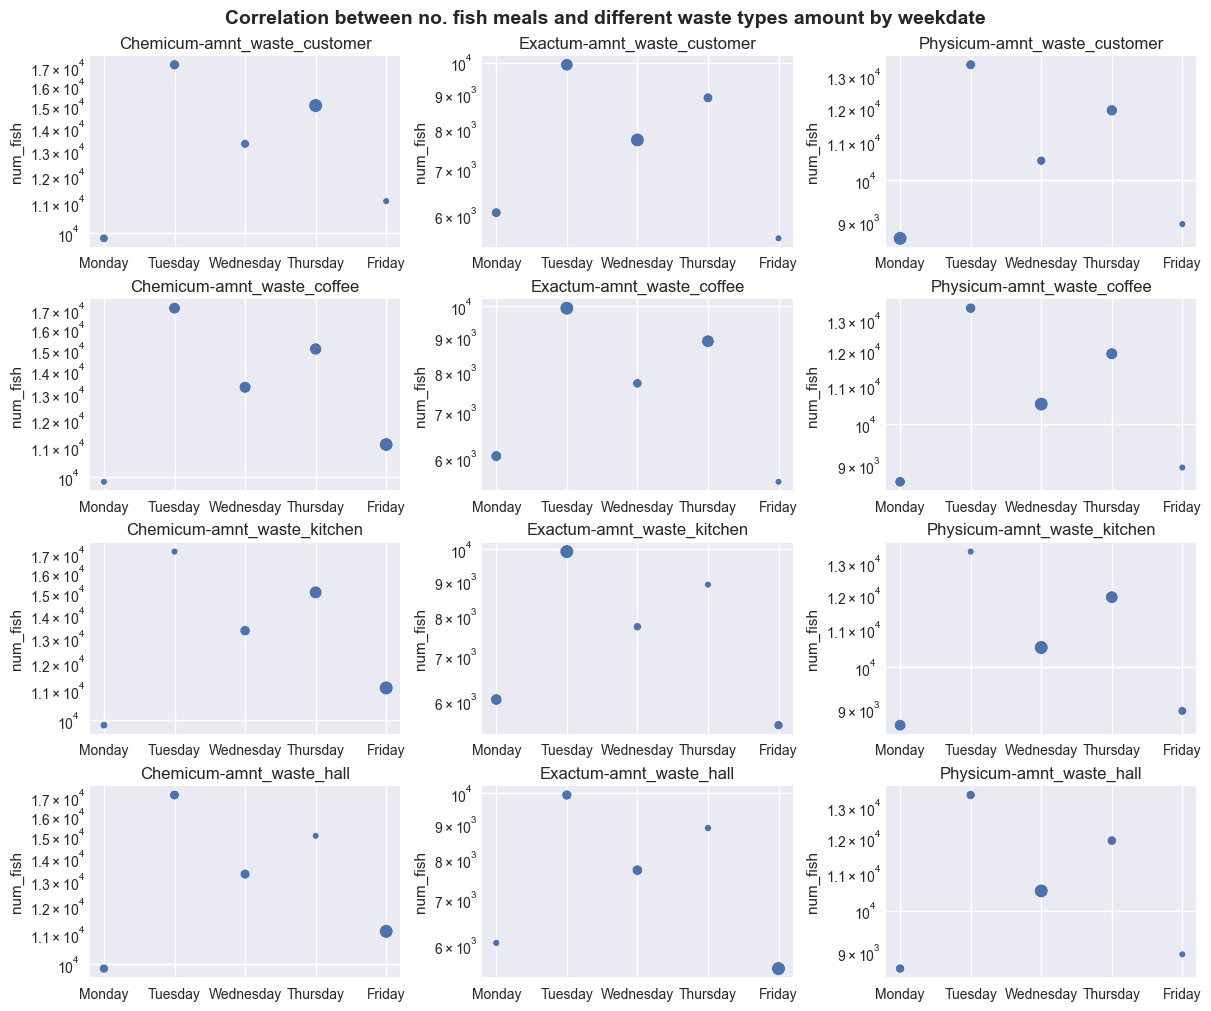

In [32]:
meal_type = "num_fish"

fig = plt.figure(figsize=(12, 10), layout="constrained")
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

fig.suptitle("Correlation between no. fish meals and different waste types amount by weekdate", fontsize=14, fontweight="bold")

i = 1
for waste in waste_types:
    for restaurant in df_meals_waste_wkdate['restaurant'].unique():
        df_restaurant = df_meals_waste_wkdate[df_meals_waste_wkdate['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)
        sns.scatterplot(df_restaurant, x='weekdate', y=meal_type, size=waste, ax=ax)
        ax.set_yscale('log')
        ax.set(xlabel=None)
        ax.get_legend().remove()
        ax.set_title(f"{restaurant}-{waste}")

        i += 1
    

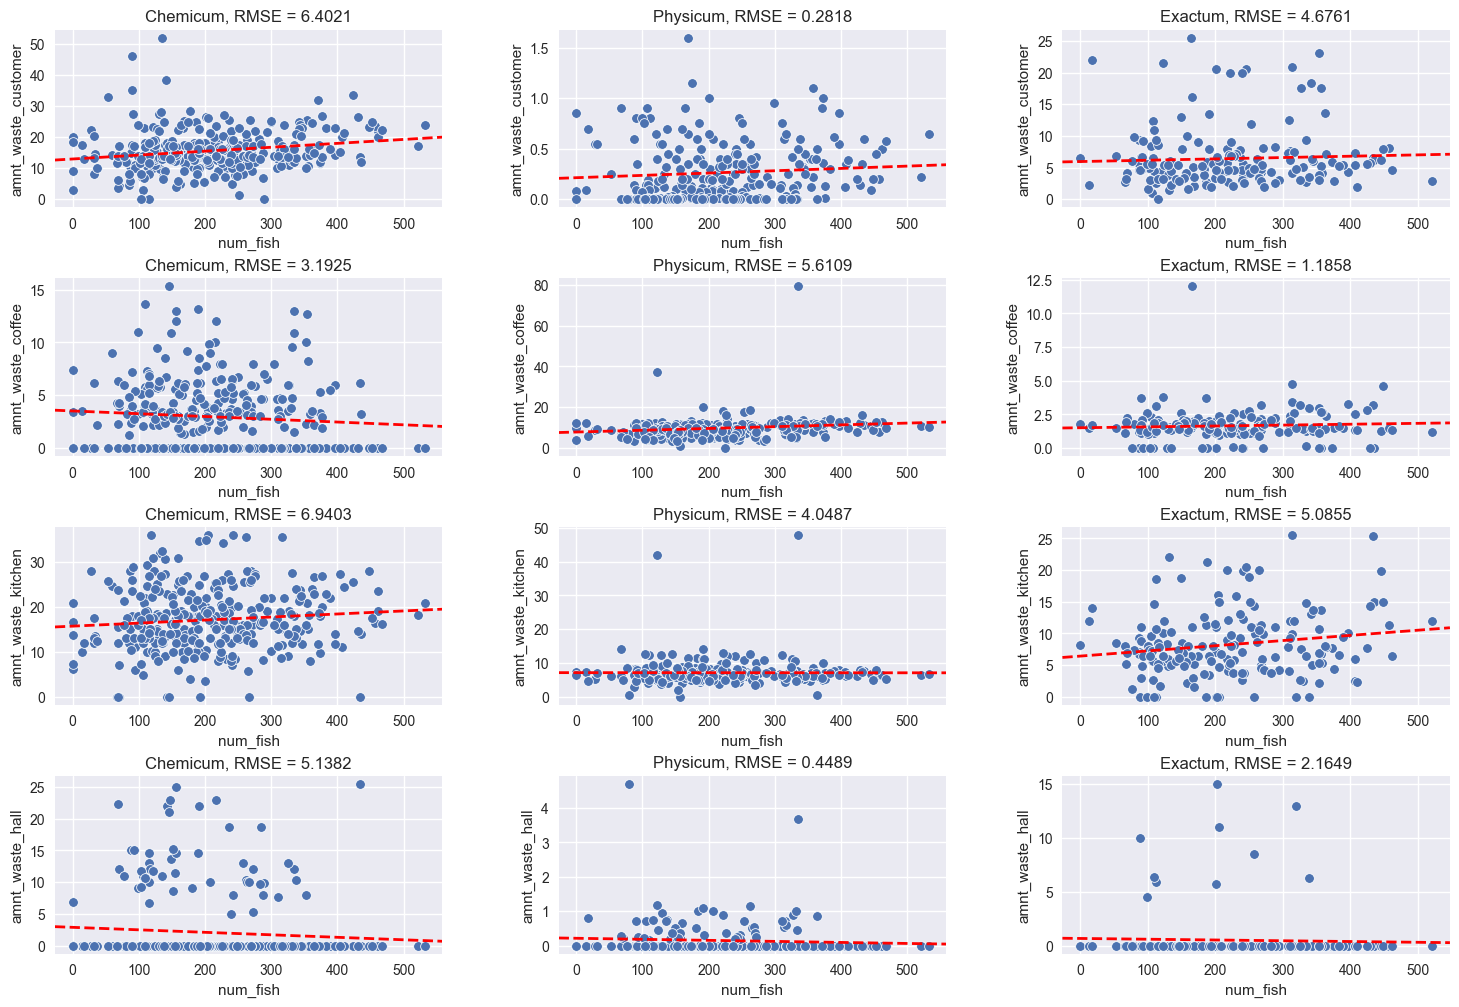

In [33]:
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

meal_type = "num_fish"
waste_types = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']
i = 1
for waste in waste_types:
    for restaurant in df_meal_waste['restaurant'].unique():

        df_restaurant = df_meal_waste[df_meal_waste['restaurant'] == restaurant]

        ax = fig.add_subplot(4, 3, i)

        sns.scatterplot(df_restaurant, x=meal_type, y=waste, ax=ax)

        regressor_linear = LinearRegression()

        X = df_restaurant[meal_type].to_numpy().reshape(-1, 1)
        y = df_restaurant[waste].to_numpy().reshape(-1, 1)
        regressor_linear.fit(X, y)

        y_pred = regressor_linear.predict(X)
        rmse_linear = root_mean_squared_error(y, y_pred)

        m, b = regressor_linear.coef_.item(), regressor_linear.intercept_.item()

        ax.axline(xy1=(0, b), slope=m, color='red', linestyle='--', linewidth=2)
        ax.set_title(f"{restaurant}, RMSE = {rmse_linear:.4f}")

        i += 1


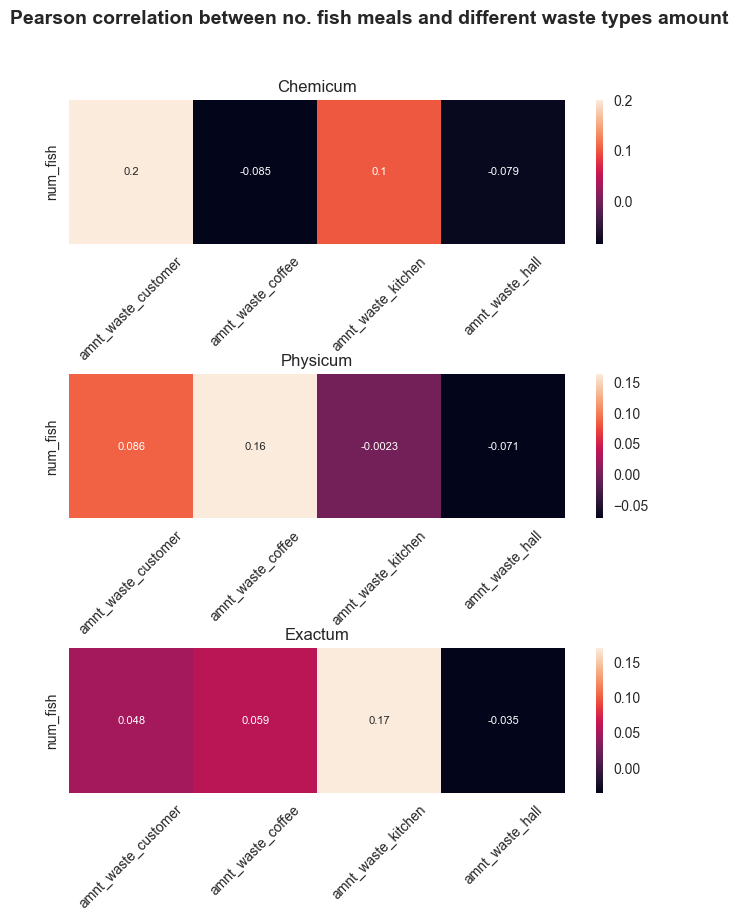

In [34]:
meal_type = "num_fish"
cols = [*meal_types, *waste_types]

fig = plt.figure(figsize=(8, 9))
plt.subplots_adjust(wspace=0.5, hspace=0.9)
fig.suptitle("Pearson correlation between no. fish meals and different waste types amount", fontsize=14, fontweight="bold")

for i, restaurant in enumerate(df_meal_waste['restaurant'].unique()):
    df_restaurant = df_meal_waste[df_meal_waste['restaurant'] == restaurant]
    line = df_restaurant[cols].corr().iloc[0]
    
    ax = fig.add_subplot(3, 1, i+1)
    sns.heatmap([line[waste_types].to_numpy()], annot=True)

    ax.set_yticklabels([str(line.name)])
    ax.set_xticklabels(line[waste_types].index)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(restaurant)